# What are autoencoders?
"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

![Autoencoder](assets/autoencoder_1.png)

1) Autoencoders are data-specific, which means that they will only be able to compress data similar to what they have been trained on. This is different from, say, the MPEG-2 Audio Layer III (MP3) compression algorithm, which only holds assumptions about "sound" in general, but not about specific types of sounds. An autoencoder trained on pictures of faces would do a rather poor job of compressing pictures of trees, because the features it would learn would be face-specific.

2) Autoencoders are lossy, which means that the decompressed outputs will be degraded compared to the original inputs (similar to MP3 or JPEG compression). This differs from lossless arithmetic compression.

3) Autoencoders are learned automatically from data examples, which is a useful property: it means that it is easy to train specialized instances of the algorithm that will perform well on a specific type of input. It doesn't require any new engineering, just appropriate training data.

https://blog.keras.io/building-autoencoders-in-keras.html


## A Simple Autoencoder based on a Fully-Connected layer

We'll start off by building a simple autoencoder to compress the MNIST dataset. With autoencoders, we pass input data through an encoder that makes a compressed representation of the input. Then, this representation is passed through a decoder to reconstruct the input data. Generally the encoder and decoder will be built with neural networks, then trained on example data.

Let's build the simplest possible autoencoder. We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

Let's get started by importing our libraries and getting the dataset.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Let's prepare our input data. We're using MNIST digits, and we're discarding the labels 
# (since we're only interested in encoding/decoding the input images).
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

Using TensorFlow backend.


We'll train an autoencoder with these images by flattening them into 784 length vectors. The images from this dataset are need to be normalized such that the values are between 0 and 1. Let's start by building basically the simplest autoencoder with a **single ReLU hidden layer**. This layer will be used as the compressed representation. Then, the encoder is the input layer and the hidden layer. The decoder is the hidden layer and the output layer. Since the images are normalized between 0 and 1, we need to use a **sigmoid activation on the output layer** to get values matching the input.

![Autoencoder architecture](assets/simple_autoencoder.png)

In [3]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [4]:
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________
None


Now let's train our autoencoder to reconstruct MNIST digits. First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

In [5]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [6]:
# We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 784))
x_test = x_test.reshape((len(x_test), 784))

In [7]:
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


Now let's train our autoencoder for 50 epochs:

In [8]:
_ = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s - loss: 0.3762 - val_loss: 0.2725
Epoch 2/50
60000/60000 [==============================] - 1s - loss: 0.2650 - val_loss: 0.2541
Epoch 3/50
60000/60000 [==============================] - 1s - loss: 0.2448 - val_loss: 0.2329
Epoch 4/50
60000/60000 [==============================] - 1s - loss: 0.2253 - val_loss: 0.2151
Epoch 5/50
60000/60000 [==============================] - 1s - loss: 0.2098 - val_loss: 0.2018
Epoch 6/50
60000/60000 [==============================] - 1s - loss: 0.1983 - val_loss: 0.1919
Epoch 7/50
60000/60000 [==============================] - 1s - loss: 0.1895 - val_loss: 0.1841
Epoch 8/50
60000/60000 [==============================] - 1s - loss: 0.1822 - val_loss: 0.1776
Epoch 9/50
60000/60000 [==============================] - 1s - loss: 0.1761 - val_loss: 0.1720
Epoch 10/50
60000/60000 [==============================] - 1s - loss: 0.1709 - val_loss: 0.1671

After 50 epochs, the autoencoder seems to reach a stable train/test loss value of about 0.11. We can try to visualize the reconstructed inputs and the encoded representations.

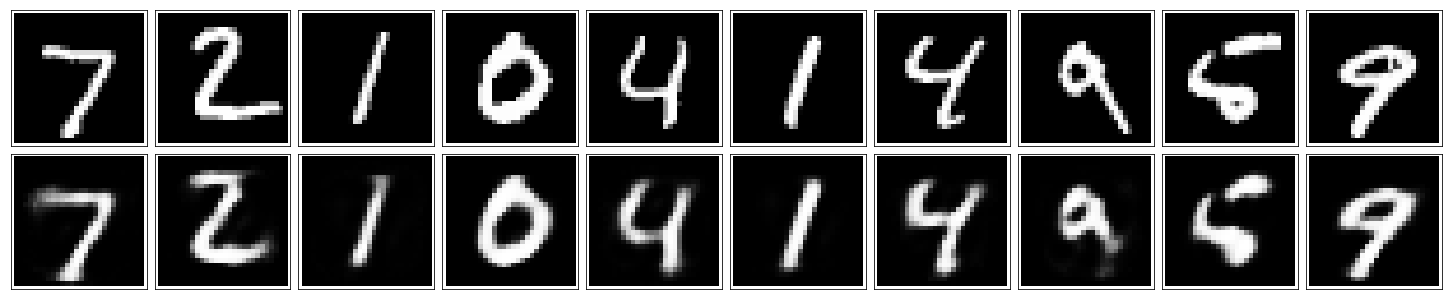

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = x_test[:10]
reconstructed = autoencoder.predict(x_test)

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

## A Deep Fully-Connected Autoencoder

We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers, such as:

In [10]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)

In [11]:
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 784)               101136    
Total para

In [12]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

_ = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s - loss: 0.3527 - val_loss: 0.2635
Epoch 2/100
60000/60000 [==============================] - 1s - loss: 0.2552 - val_loss: 0.2454
Epoch 3/100
60000/60000 [==============================] - 1s - loss: 0.2380 - val_loss: 0.2281
Epoch 4/100
60000/60000 [==============================] - 1s - loss: 0.2214 - val_loss: 0.2119
Epoch 5/100
60000/60000 [==============================] - 1s - loss: 0.2041 - val_loss: 0.1983
Epoch 6/100
60000/60000 [==============================] - 1s - loss: 0.1945 - val_loss: 0.1897
Epoch 7/100
60000/60000 [==============================] - 1s - loss: 0.1869 - val_loss: 0.1830
Epoch 8/100
60000/60000 [==============================] - 1s - loss: 0.1807 - val_loss: 0.1770
Epoch 9/100
60000/60000 [==============================] - 1s - loss: 0.1756 - val_loss: 0.1718
Epoch 10/100
60000/60000 [==============================] - 1s - loss: 0.1708 - val_lo

60000/60000 [==============================] - 1s - loss: 0.1052 - val_loss: 0.1042
Epoch 86/100
60000/60000 [==============================] - 2s - loss: 0.1050 - val_loss: 0.1040
Epoch 87/100
60000/60000 [==============================] - 1s - loss: 0.1048 - val_loss: 0.1031
Epoch 88/100
60000/60000 [==============================] - 1s - loss: 0.1047 - val_loss: 0.1037
Epoch 89/100
60000/60000 [==============================] - 2s - loss: 0.1045 - val_loss: 0.1043
Epoch 90/100
60000/60000 [==============================] - 2s - loss: 0.1044 - val_loss: 0.1035
Epoch 91/100
60000/60000 [==============================] - 2s - loss: 0.1042 - val_loss: 0.1032
Epoch 92/100
60000/60000 [==============================] - 2s - loss: 0.1040 - val_loss: 0.1032
Epoch 93/100
60000/60000 [==============================] - 2s - loss: 0.1037 - val_loss: 0.1023
Epoch 94/100
60000/60000 [==============================] - 2s - loss: 0.1036 - val_loss: 0.1024
Epoch 95/100
60000/60000 [=================

After 100 epochs, it reaches a train and test loss of ~0.1020, a bit better than our previous models. Our reconstructed digits look a bit better too:

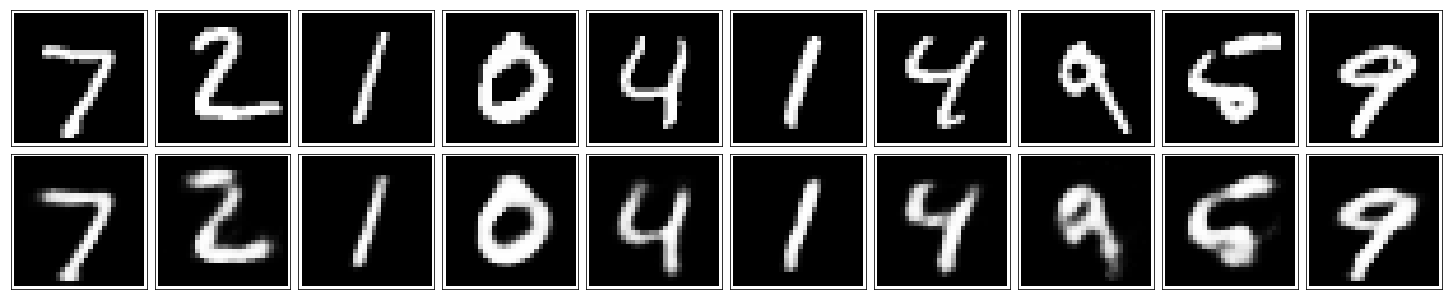

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline 
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = x_test[:10]
reconstructed = autoencoder.predict(x_test)

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

## A Deep Convolutional Autoencoder

Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.


### Network Architecture

Let's implement one. The encoder will consist in a stack of `Conv2D` and `MaxPooling2D` layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of `Conv2D` and `UpSampling2D` layers.

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image.

In [14]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
# Now 28x28x1

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
# Now 28x28x16
x = MaxPooling2D((2, 2), padding='same')(x)
# Now 14x14x16
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# Now 14x14x8
x = MaxPooling2D((2, 2), padding='same')(x)
# Now 7x7x8
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# Now 7x7x8
encoded = MaxPooling2D((2, 2), padding='same')(x)
# Now 4x4x8

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
# Now 4x4x8
x = UpSampling2D((2, 2))(x)
# Now 8x8x8
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# Now 8x8x8
x = UpSampling2D((2, 2))(x)
# Now 16x16x8
x = Conv2D(16, (3, 3), activation='relu')(x)
# Now 14x14x16
x = UpSampling2D((2, 2))(x)
# Now 28x28x16
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
# Now 28x28x1

autoencoder = Model(input_img, decoded)

In [15]:
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
__________

In [16]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [17]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [18]:
_ = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 18s - loss: 0.2285 - val_loss: 0.1822
Epoch 2/50
60000/60000 [==============================] - 15s - loss: 0.1690 - val_loss: 0.1618
Epoch 3/50
60000/60000 [==============================] - 15s - loss: 0.1524 - val_loss: 0.1491
Epoch 4/50
60000/60000 [==============================] - 14s - loss: 0.1435 - val_loss: 0.1390
Epoch 5/50
60000/60000 [==============================] - 14s - loss: 0.1378 - val_loss: 0.1330
Epoch 6/50
60000/60000 [==============================] - 14s - loss: 0.1334 - val_loss: 0.1302
Epoch 7/50
60000/60000 [==============================] - 14s - loss: 0.1297 - val_loss: 0.1265
Epoch 8/50
60000/60000 [==============================] - 14s - loss: 0.1272 - val_loss: 0.1235
Epoch 9/50
60000/60000 [==============================] - 14s - loss: 0.1250 - val_loss: 0.1228
Epoch 10/50
60000/60000 [==============================] - 14s - loss: 0.1236 - val_lo

In the Keras blog the model converges to a loss of 0.094, significantly better than our previous models (this is in large part due to the higher entropic capacity of the encoded representation, 128 dimensions vs. 32 previously). Let's take a look at the reconstructed digits:

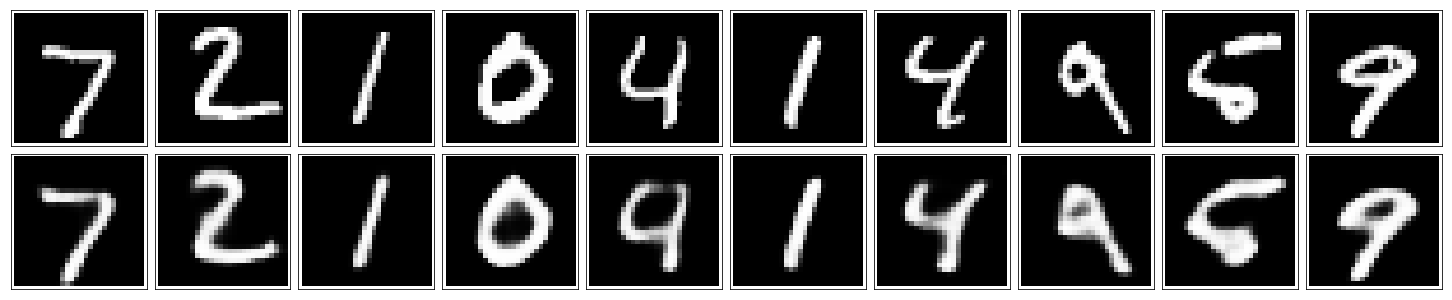

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline 
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = x_test[:10]
reconstructed = autoencoder.predict(x_test)

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

## Application to Image Denoising

Autoencoders like the ones we've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images generated and the denoised images.

In [20]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.) # random noise may introduce values < 0 or > 1, so clip
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

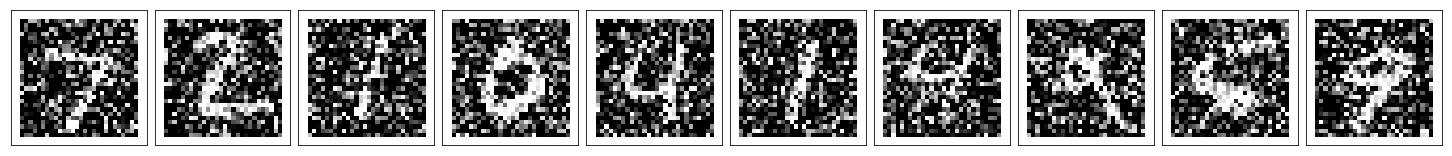

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(20,2))
in_imgs = x_test_noisy[:10]

for img, ax in zip(in_imgs, axes):
    ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

If we squint we can still recognize them, but barely. Can our autoencoder learn to recover the original digits? Let's find out.

Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, we'll use a slightly different model with more filters per layer:

In [22]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

In [23]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [24]:
_ = autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 22s - loss: 0.1959 - val_loss: 0.1315
Epoch 2/100
60000/60000 [==============================] - 21s - loss: 0.1249 - val_loss: 0.1164
Epoch 3/100
60000/60000 [==============================] - 21s - loss: 0.1157 - val_loss: 0.1103
Epoch 4/100
60000/60000 [==============================] - 21s - loss: 0.1115 - val_loss: 0.1080
Epoch 5/100
60000/60000 [==============================] - 21s - loss: 0.1089 - val_loss: 0.1082
Epoch 6/100
60000/60000 [==============================] - 21s - loss: 0.1068 - val_loss: 0.1040
Epoch 7/100
60000/60000 [==============================] - 21s - loss: 0.1053 - val_loss: 0.1029
Epoch 8/100
60000/60000 [==============================] - 21s - loss: 0.1041 - val_loss: 0.1020
Epoch 9/100
60000/60000 [==============================] - 21s - loss: 0.1032 - val_loss: 0.1015
Epoch 10/100
60000/60000 [==============================] - 21s - loss: 0.102

It seems to work pretty well after adding noise to the test images and passing them through the autoencoder. It does a suprising great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

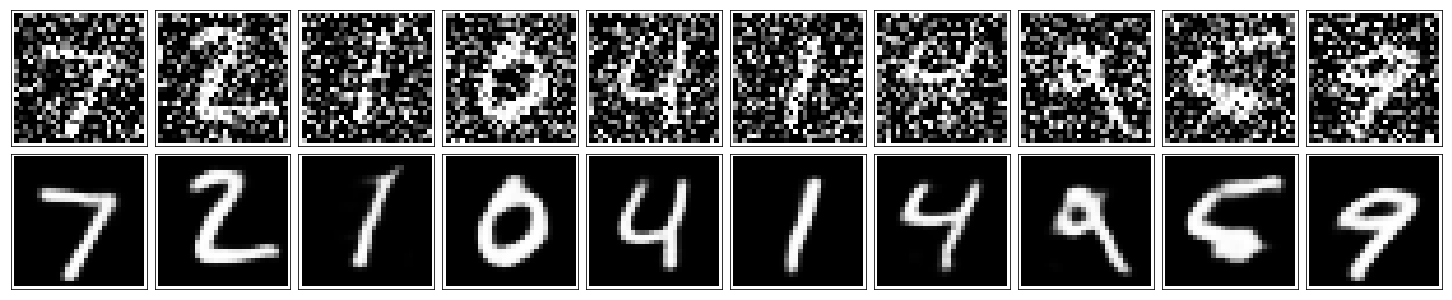

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = x_test_noisy[:10]
reconstructed = autoencoder.predict(x_test_noisy)

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)